In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pylamp.loss.losses import BCELoss
from matplotlib import pyplot as plt
from pylamp.neural.sequentiel import Sequentiel
from pylamp.neural.layers import Linear
from pylamp.optim.optimizer import Optim
from pylamp.neural.activations import TanH, Sigmoid
from pylamp.optim.optimizer import SGD
from pylamp.utils.usps import load_usps, show_usps

In [3]:
def plot_loss(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses, label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Loading Data

In [4]:
uspsdatatrain = "./data/USPS/USPS_train.txt"
uspsdatatest = "./data/USPS/USPS_test.txt"
X_train, y_train = load_usps(uspsdatatrain)
X_test, y_test = load_usps(uspsdatatest)

## Autoencoder on USPS data

• Encodage : Linear(256,100) → TanH() → Linear(100,10) → TanH()

• Décodage : Linear(10,100) → TanH() → Linear(100,256) → Sigmoide()

### One big Sequentiel

In [17]:
autoencoder = Sequentiel()
autoencoder.add_module(Linear(256,100))
autoencoder.add_module(TanH())
autoencoder.add_module(Linear(100,10))
autoencoder.add_module(TanH())
autoencoder.add_module(Linear(10,100))
autoencoder.add_module(TanH())
autoencoder.add_module(Linear(100,256))
autoencoder.add_module(Sigmoid())


loss = BCELoss()

optimizer_autoencoder = Optim(autoencoder,loss,1e-3)

autoencoder_losses = SGD(optimizer_autoencoder,X_train, X_train, batch_size=256,epochs=300,verbose=True)

Epoch 1/300, Average Loss: 3.203453673413399
Epoch 31/300, Average Loss: -0.02500098265028305
Epoch 61/300, Average Loss: -0.3676292716120015
Epoch 91/300, Average Loss: -0.5470695411905816
Epoch 121/300, Average Loss: -0.6689136777923924
Epoch 151/300, Average Loss: -0.7474427434186772
Epoch 181/300, Average Loss: -0.7966306439314749
Epoch 211/300, Average Loss: -0.851142955631097
Epoch 241/300, Average Loss: -0.8912799885137218
Epoch 271/300, Average Loss: -0.9225784025238281
Training finished.


Original and AutoEncoder output:


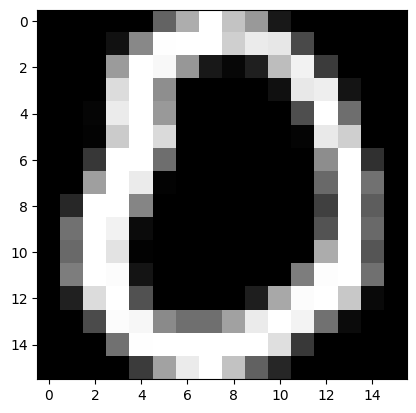

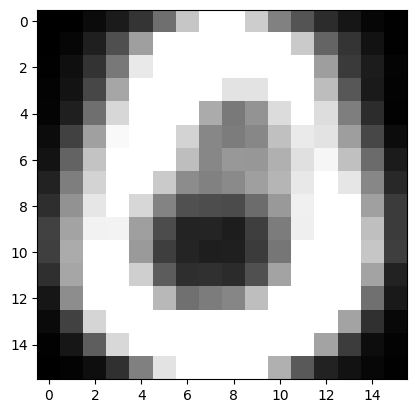

In [50]:
testing = np.array([X_test[40]])
testing_pred = autoencoder.forward(testing)
print("Original VS AutoEncoder output:")
show_usps(testing)
plt.figure()
show_usps(testing_pred)

### Seperating encoder and decoder into two sequentiels

In [39]:
autoencoder = Sequentiel()

encoder = Sequentiel()
encoder.add_module(Linear(256,100))
encoder.add_module(TanH())
encoder.add_module(Linear(100,10))
encoder.add_module(TanH())

decoder = Sequentiel()
decoder.add_module(Linear(10,100))
decoder.add_module(TanH())
decoder.add_module(Linear(100,256))
decoder.add_module(Sigmoid())

autoencoder.add_module(encoder)
autoencoder.add_module(decoder)

loss = BCELoss()

optimizer_autoencoder = Optim(autoencoder,loss,1e-3)

autoencoder_losses = SGD(optimizer_autoencoder,X_train, X_train, batch_size=256,epochs=1000,verbose=True)

Epoch 1/1000, Average Loss: 3.4406880544153275
Epoch 101/1000, Average Loss: -0.42549097833621874
Epoch 201/1000, Average Loss: -0.6577416081838159
Epoch 301/1000, Average Loss: -0.7305174698574196
Epoch 401/1000, Average Loss: -0.7759339429592391
Epoch 501/1000, Average Loss: -0.802439119553089
Epoch 601/1000, Average Loss: -0.8401906476135865
Epoch 701/1000, Average Loss: -0.8782061972205852
Epoch 801/1000, Average Loss: -0.9042906806192493
Epoch 901/1000, Average Loss: -0.9311778068218315
Training finished.


encoded=array([[-1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,  1.]])
Original VS AutoEncoder output:


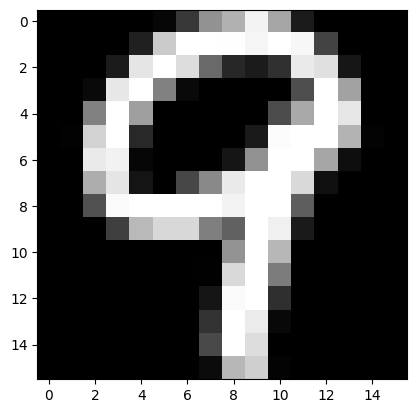

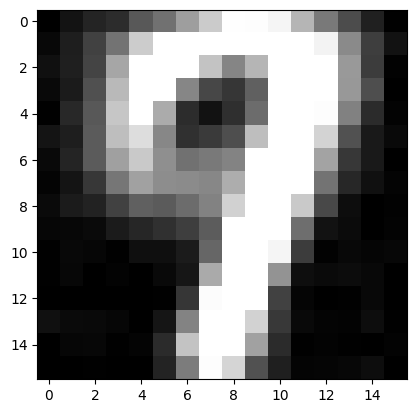

In [53]:
testing = np.array([X_test[0]])
encoded = encoder.forward(testing)
print(f"{encoded=}")
decoded = decoder.forward(encoded)
print("Original VS AutoEncoder output:")
show_usps(testing)
plt.figure()
show_usps(decoded)